In [8]:
!pip install numpy opencv-python torch rawpy


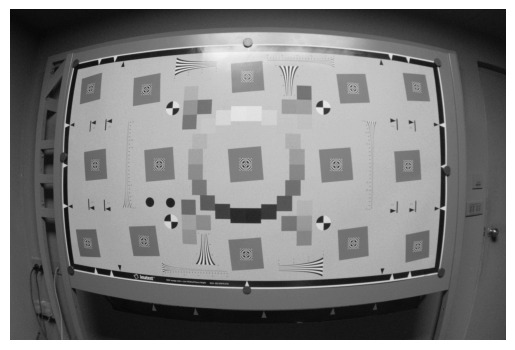

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define image properties
width, height = 1920, 1280
bit_depth = 12  # 12-bit depth, adjust if needed

# Read raw data
file_path = r"D:\PYTHON\eSFR_1920x1280_12b_GRGB_6500K_60Lux.raw"
with open(file_path, 'rb') as f:
    raw_data = np.fromfile(f, dtype=np.uint16)  # Use uint16 assuming 12-bit packed data fits

# Reshape the raw data to the correct dimensions
raw_image = raw_data.reshape((height, width))

# Scale the image to 8-bit for viewing (0-255 range)
raw_image_8bit = (raw_image / raw_image.max() * 255).astype(np.uint8)

# Display the image using matplotlib
plt.imshow(raw_image_8bit, cmap='gray')
plt.axis('off')  # Hide axis for a cleaner display
plt.show()


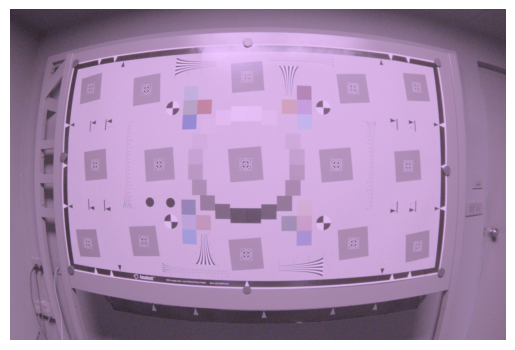

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define image properties
width, height = 1920, 1280
bit_depth = 12  # Adjust based on your file's bit depth

# Load raw Bayer data
file_path = r"D:\PYTHON\eSFR_1920x1280_12b_GRGB_6500K_60Lux.raw"
with open(file_path, 'rb') as f:
    raw_data = np.fromfile(f, dtype=np.uint16)  # Assuming 12-bit packed data fits in 16 bits

# Reshape to match the image dimensions
raw_image = raw_data.reshape((height, width))

# Scale the data to fit OpenCV's requirements (0-4095 range for 12-bit)
# Ensure max value for 12-bit images is 4095 for proper scaling
if raw_image.max() > 4095:
    raw_image = np.clip(raw_image, 0, 4095)
raw_image = (raw_image / 4095 * 255).astype(np.uint8)

# Step 2: Demosaicing (assuming Bayer GRBG pattern)
demosaiced_image = cv2.cvtColor(raw_image, cv2.COLOR_BayerGR2RGB)

# Step 3: Apply White Balance
# This is a simple white balance; you may need to adjust multipliers depending on the image
# Set channel multipliers for each color (these are rough estimates)
red_gain, green_gain, blue_gain = 1.5, 1.0, 1.8  # Adjust based on your needs
white_balanced_image = demosaiced_image.copy()
white_balanced_image[:, :, 0] = np.clip(white_balanced_image[:, :, 0] * red_gain, 0, 255)
white_balanced_image[:, :, 1] = np.clip(white_balanced_image[:, :, 1] * green_gain, 0, 255)
white_balanced_image[:, :, 2] = np.clip(white_balanced_image[:, :, 2] * blue_gain, 0, 255)

# Step 4: Gamma Correction (to convert linear image to sRGB)
gamma = 2.2
gamma_corrected_image = np.power(white_balanced_image / 255.0, 1 / gamma) * 255
gamma_corrected_image = gamma_corrected_image.astype(np.uint8)

# Display the final preprocessed image
plt.imshow(gamma_corrected_image)
plt.axis('off')
plt.show()


In [11]:
!pip install torch


In [12]:
import torch

# Path to your downloaded model
model_path = r"D:\PYTHON\ffdnet-pytorch\ffdnet-pytorch\models\net_rgb.pth"  # Adjust path if needed

# Load the model
model = torch.load(model_path, map_location='cpu', weights_only=True)  # Use 'cpu' if you don’t have a GPU
print("Model loaded successfully!")


Model loaded successfully!


In [15]:
!pip install torch torchvision pillow numpy


In [17]:
import sys
sys.path.append("D:\PYTHON\ffdnet-pytorch\ffdnet-pytorch")  # Change this to the path where FFDNet.py is located


In [19]:
import sys
import torch
from PIL import Image
import numpy as np

# Add the FFDNet directory to your path
sys.path.append(r"D:\PYTHON\ffdnet-pytorch\ffdnet-pytorch")  # Adjust this path if needed

from ffdnet import FFDNet  # Adjust the import based on your directory structure

# Path to your downloaded model
model_path = r"D:\PYTHON\ffdnet-pytorch\ffdnet-pytorch\models\net_rgb.pth"  # Adjust path if needed

# Load the model with 3 input channels (for RGB)
model = FFDNet(num_input_channels=3)  # Initialize the model with 3 input channels
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)  # Load the model weights
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")

# Load and process the RAW image as RGB to match model's channel requirement
input_img_path = "D:\\PYTHON\\eSFR_1920x1280_12b_GRGB_6500K_60Lux.raw"
input_img = np.fromfile(input_img_path, dtype=np.uint16)  # Load RAW image data
input_img = input_img.reshape((1280, 1920))  # Reshape based on image dimensions

# Convert to a PIL Image and then to a PyTorch tensor
input_img = Image.fromarray(input_img).convert('RGB')  # Convert to RGB
input_tensor = torch.from_numpy(np.array(input_img)).float() / 255.0  # Normalize to [0, 1]
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension and change to (C, H, W)

# Set the noise level
noise_sigma = torch.tensor([0.1], dtype=torch.float32)  # Adjust noise_sigma as needed (e.g., 0.1 for moderate noise)

# Denoise the image (pass both the input tensor and noise_sigma to the model)
with torch.no_grad():  # Disable gradient calculation
    denoised_img = model(input_tensor, noise_sigma)  # Apply the model with noise_sigma

# Post-process and convert the output tensor back to an image format
denoised_img = denoised_img.squeeze(0).permute(1, 2, 0).numpy()  # Remove batch dimension and permute back to (H, W, C)
denoised_img = (denoised_img * 255).astype(np.uint8)

# Display or save the denoised image
denoised_image_pil = Image.fromarray(denoised_img)
denoised_image_pil.show()  # Display the denoised image
# denoised_image_pil.save('denoised_image.png')  # Optionally save the image


C:\Users\HP\AppData\Local\Temp\ipykernel_254704\584110550.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torc

Model loaded successfully!


In [20]:
!pip install scikit-image


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.0 MB/s eta 0:00:07
   --- ------------------------------------ 1.0/12.9 MB 2.0 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.9 MB 1.8 MB/s eta 0:00:07
   ---- ----------------------------------- 1.6/12.9 MB 1.6 MB/s eta 0:00:07
   ----- ---------------------------------- 1.8/12.9 MB 1.3 MB/s eta 0:00:09
   ----- ---------------------------------- 1.8/12.9 MB 1.3 MB/s eta 0:00:09
   ----- ---------------------------------- 1.8/12.9 MB 1.3 MB/s eta 0:00:09
   ------ --------------------------------- 2.1/12.9 MB 1.1 MB/s eta 0:00:10
   ------ --------------------------------- 2.1/12.9 MB 1.1 MB/s eta 0:00:10
   ------- -------------------------------- 2.4/12.9 MB 1.0 MB/s eta 0:00:11
   ------- ---------

In [23]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Assuming original_img and denoised_img_np are the original and denoised images
# Ensure both images are in the correct format (e.g., [H, W, C] with values in [0, 255])

# Calculate PSNR
psnr_value = psnr(original_img, denoised_img_np, data_range=255)
print(f"PSNR: {psnr_value:.2f} dB")

# Calculate SSIM with specified window size and channel handling
ssim_value = ssim(original_img, denoised_img_np, data_range=255, channel_axis=-1, win_size=3)
print(f"SSIM: {ssim_value:.4f}")


PSNR: 51.05 dB
SSIM: 0.9962


In [24]:
import cv2
import numpy as np
from PIL import Image

# Load the original image
input_img_path = "D:\\PYTHON\\eSFR_1920x1280_12b_GRGB_6500K_60Lux.raw"
original_img = np.fromfile(input_img_path, dtype=np.uint16).reshape((1280, 1920))
original_img = (original_img / 4095 * 255).astype(np.uint8)  # Normalize to 8-bit range for display

# Convert to a 3-channel RGB image for visualization purposes
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

# Apply Laplacian filter
laplacian_enhanced_img = cv2.Laplacian(original_img, cv2.CV_64F)
laplacian_enhanced_img = np.clip(laplacian_enhanced_img, 0, 255).astype(np.uint8)
laplacian_enhanced_rgb = cv2.cvtColor(laplacian_enhanced_img, cv2.COLOR_GRAY2RGB)

# Display or save the Laplacian enhanced image
Image.fromarray(laplacian_enhanced_rgb).show()
# Save if needed: Image.fromarray(laplacian_enhanced_rgb).save("laplacian_enhanced.png")


In [25]:
# Assume denoised_img_np is the denoised image from Assignment 2

# Convert denoised image to grayscale for comparison
denoised_gray = cv2.cvtColor(denoised_img_np, cv2.COLOR_RGB2GRAY)


In [29]:
# Gradient for Laplacian-enhanced image
laplacian_sobel_x = cv2.Sobel(laplacian_enhanced_img, cv2.CV_64F, 1, 0, ksize=3)
laplacian_sobel_y = cv2.Sobel(laplacian_enhanced_img, cv2.CV_64F, 0, 1, ksize=3)
laplacian_edge_strength = np.sqrt(laplacian_sobel_x**2 + laplacian_sobel_y**2)
laplacian_edge_strength = np.clip(laplacian_edge_strength, 0, 255).astype(np.uint8)

# Gradient for denoised image
denoised_sobel_x = cv2.Sobel(denoised_gray, cv2.CV_64F, 1, 0, ksize=3)
denoised_sobel_y = cv2.Sobel(denoised_gray, cv2.CV_64F, 0, 1, ksize=3)
denoised_edge_strength = np.sqrt(denoised_sobel_x**2 + denoised_sobel_y**2)
denoised_edge_strength = np.clip(denoised_edge_strength, 0, 255).astype(np.uint8)

# Display edge strength images
Image.fromarray(laplacian_edge_strength).show()
Image.fromarray(denoised_edge_strength).show()
# Save if needed:
Image.fromarray(laplacian_edge_strength).save("laplacian_edge_strength.png")
Image.fromarray(denoised_edge_strength).save("denoised_edge_strength.png")
